In [2]:
!pip install kagglehub


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mssmartypants/rice-type-classification")

print("Path to dataset files:", path)

100%|██████████| 888k/888k [00:00<00:00, 1.33MB/s]

Extracting files...
Path to dataset files: C:\Users\VICTUS\.cache\kagglehub\datasets\mssmartypants\rice-type-classification\versions\2


In [6]:
!pip install torchsummary

In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device ="cuda" if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [10]:
data_df = pd.read_csv('C:/Users/VICTUS/.cache/kagglehub/datasets/mssmartypants/rice-type-classification/versions/2/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [14]:
data_df.dropna(inplace = True)
data_df.drop(['id'],axis=1,inplace = True)

KeyError: "['id'] not found in axis"

In [15]:
data_df.shape

(18185, 11)

In [16]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [17]:
print(data_df['Class'].unique(
))

[1 0]


In [19]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [22]:
 original_df = data_df.copy()
for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [24]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [25]:
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.3)

In [26]:
x_test,x_val,y_test,y_val= train_test_split(x_test,y_test,test_size=0.5)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [35]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X=torch.tensor(X,dtype =torch.float32).to(device)
        self.Y=torch.tensor(Y,dtype =torch.float32).to(device)
   
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self,index):
        return self.X[index],self.Y[index]
        

In [36]:
training_data= dataset(x_train,y_train)
validation_data= dataset(x_val,y_val)
testing_data= dataset(x_test,y_test)

In [54]:
train_dataloader = DataLoader(training_data,batch_size=32,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=32,shuffle=True)
testing_dataloader = DataLoader(testing_data,batch_size=32,shuffle=True)

In [55]:
Hidden_Neurons =10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.input_layer = nn.Linear(X.shape[1],Hidden_Neurons)
        self.linear= nn.Linear(Hidden_Neurons,1)
        self.sigmoid= nn.Sigmoid()

    def forward(self,x):
        x= self.input_layer(x)
        x=self.linear(x)
        x=self.sigmoid(x)
        return x
model = MyModel().to(device)
        

In [56]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [57]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr =1e-3)

In [58]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

epoches = 10
for epoch in range(epoches):
    total_loss_train=0
    total_loss_validation=0
    total_acc_train=0
    total_acc_validation=0

    for data in train_dataloader:
        inputs,labels=data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction,labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()
        total_acc_train +=acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        for data in validation_dataloader:
            inputs,labels=data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction,labels)
            total_loss_validation += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()
            total_acc_validation +=acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_validation/1000,4))
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4))

    print(f''' Epoche no.{epoch+1} train Loss : {round(total_loss_train/1000,4)} train Accuracy {round(total_acc_train/training_data.__len__()*100 ,4)}
                validation loss: {round(total_loss_validation/1000,4)}  validation Accuracy :{round(total_acc_validation/validation_data.__len__()*100,4)} ''')
    print('='*50)
    

 Epoche no.1 train Loss : 0.2404 train Accuracy 75.6776
                validation loss: 0.0389  validation Accuracy :97.8006 
 Epoche no.2 train Loss : 0.118 train Accuracy 97.3289
                validation loss: 0.0161  validation Accuracy :98.2771 
 Epoche no.3 train Loss : 0.0554 train Accuracy 98.1852
                validation loss: 0.0091  validation Accuracy :98.3138 
 Epoche no.4 train Loss : 0.0355 train Accuracy 98.3816
                validation loss: 0.0065  validation Accuracy :98.607 
 Epoche no.5 train Loss : 0.0273 train Accuracy 98.5231
                validation loss: 0.0053  validation Accuracy :98.607 
 Epoche no.6 train Loss : 0.0232 train Accuracy 98.5781
                validation loss: 0.0046  validation Accuracy :98.7903 
 Epoche no.7 train Loss : 0.0208 train Accuracy 98.5781
                validation loss: 0.0042  validation Accuracy :98.827 
 Epoche no.8 train Loss : 0.0193 train Accuracy 98.6173
                validation loss: 0.0039  validation Accurac

In [60]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0
    for data in testing_dataloader:
        inputs,labels=data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction,labels)
        total_loss_test += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_test +=acc

    print(f'''Accuracy {round(total_acc_test/testing_data.__len__()*100 ,4)} ''')
    print('='*50)
    
        

Accuracy 98.6437 


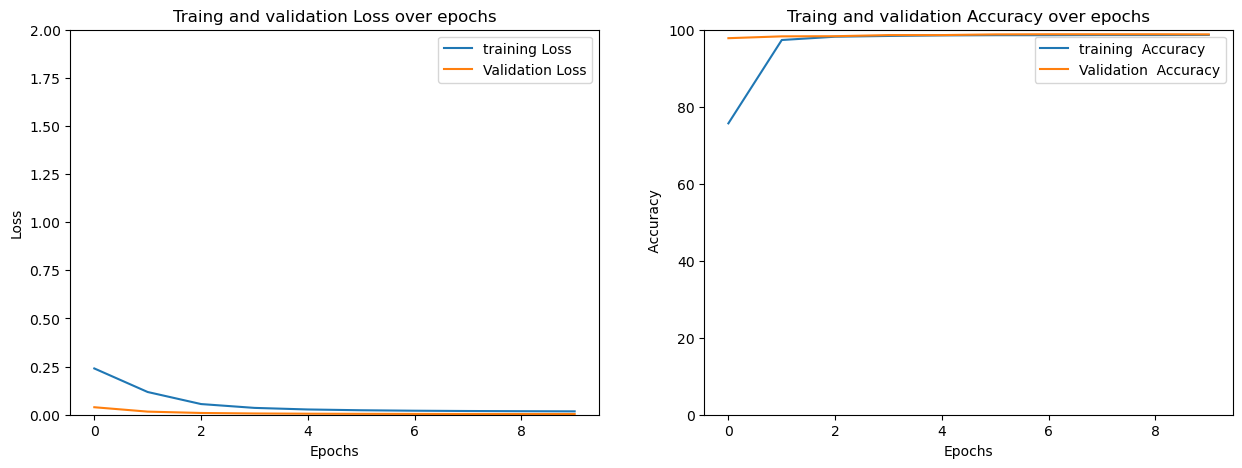

In [62]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot,label = 'training Loss')
axs[0].plot(total_loss_validation_plot,label = 'Validation Loss')
axs[0].set_title('Traing and validation Loss over epochs')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = 'training  Accuracy')
axs[1].plot(total_acc_validation_plot,label = 'Validation  Accuracy')
axs[1].set_title('Traing and validation Accuracy over epochs')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel(" Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

